In [1]:
#importing the necesary libraires
import pandas as pd
import mlflow
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn.feature_extraction import DictVectorizer

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler,LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split


from sklearn.impute import SimpleImputer

from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

import parfit.parfit as pf

import pickle


In [2]:
sklearn.__version__

'1.2.2'

In [3]:
df_accepted = pd.read_csv('../../assets/data/accepted_2007_to_2018Q4.csv.gz', compression='gzip', header=0, sep=',', quotechar='"')

df_rejected = pd.read_csv('../../assets/data/rejected_2007_to_2018Q4.csv.gz', compression='gzip', header=0, sep=',', quotechar='"')

C:\Users\Bertr\AppData\Local\Temp\ipykernel_22784\764452105.py:1: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  df_accepted = pd.read_csv('../../assets/data/accepted_2007_to_2018Q4.csv.gz', compression='gzip', header=0, sep=',', quotechar='"')


In [4]:
df_accepted.shape



(2260701, 151)

In [5]:
df_rejected.shape

(27648741, 9)

In [6]:
pd.options.display.max_rows = 1000

In [7]:
df_rejected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27648741 entries, 0 to 27648740
Data columns (total 9 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Amount Requested      float64
 1   Application Date      object 
 2   Loan Title            object 
 3   Risk_Score            float64
 4   Debt-To-Income Ratio  object 
 5   Zip Code              object 
 6   State                 object 
 7   Employment Length     object 
 8   Policy Code           float64
dtypes: float64(3), object(6)
memory usage: 1.9+ GB


In [8]:
df_accepted.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Data columns (total 151 columns):
 #    Column                                      Non-Null Count    Dtype  
---   ------                                      --------------    -----  
 0    id                                          2260701 non-null  object 
 1    member_id                                   0 non-null        float64
 2    loan_amnt                                   2260668 non-null  float64
 3    funded_amnt                                 2260668 non-null  float64
 4    funded_amnt_inv                             2260668 non-null  float64
 5    term                                        2260668 non-null  object 
 6    int_rate                                    2260668 non-null  float64
 7    installment                                 2260668 non-null  float64
 8    grade                                       2260668 non-null  object 
 9    sub_grade                                   

In [9]:
#dropping the accepted loans additionnal columns as they are not neede to train or loans acceptability model
df_accepted_clean = df_accepted[['loan_amnt','issue_d','title','dti','zip_code','addr_state','emp_length','policy_code']].copy()

In [10]:
df_accepted_clean['risk_score'] = df_accepted[['fico_range_low','fico_range_high']].mean(axis=1)
df_accepted_clean.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Data columns (total 9 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   loan_amnt    2260668 non-null  float64
 1   issue_d      2260668 non-null  object 
 2   title        2237343 non-null  object 
 3   dti          2258957 non-null  float64
 4   zip_code     2260667 non-null  object 
 5   addr_state   2260668 non-null  object 
 6   emp_length   2113761 non-null  object 
 7   policy_code  2260668 non-null  float64
 8   risk_score   2260668 non-null  float64
dtypes: float64(4), object(5)
memory usage: 155.2+ MB


In [11]:
df_rejected.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27648741 entries, 0 to 27648740
Data columns (total 9 columns):
 #   Column                Non-Null Count     Dtype  
---  ------                --------------     -----  
 0   Amount Requested      27648741 non-null  float64
 1   Application Date      27648741 non-null  object 
 2   Loan Title            27647438 non-null  object 
 3   Risk_Score            9151111 non-null   float64
 4   Debt-To-Income Ratio  27648741 non-null  object 
 5   Zip Code              27648448 non-null  object 
 6   State                 27648719 non-null  object 
 7   Employment Length     26697386 non-null  object 
 8   Policy Code           27647823 non-null  float64
dtypes: float64(3), object(6)
memory usage: 1.9+ GB


In [12]:
#combining the data 


# Add the 'accepted' column to both dataframes
df_accepted_clean['accepted'] = 1
df_rejected['accepted'] = 0

# Rename the columns in the Rejected dataframe to match the column names in the Accepted dataframe
df_rejected = df_rejected.rename(columns={'Loan Title': 'title',
                                          'Policy Code': 'policy_code',
                                          'Risk_Score': 'risk_score'})
df_accepted_clean = df_accepted_clean.rename(columns={'loan_amnt': 'Amount Requested',
                                          'issue_d': 'Application Date',                                          
                                          'dti': 'Debt-To-Income Ratio',
                                          'zip_code': 'Zip Code',
                                          'addr_state': 'State',
                                          'emp_length': 'Employment Length'})



# Concatenate the dataframes vertically
df_combined = pd.concat([df_accepted_clean, df_rejected], ignore_index=True)

# reset the index to have a clean index for the combined dataframe
df_combined.reset_index(drop=True, inplace=True)

In [13]:
df_combined = df_combined.drop(columns=['Application Date', 'title', 'Zip Code', 'State'])



In [14]:
df_combined.isna().sum()

Amount Requested              33
Debt-To-Income Ratio        1744
Employment Length        1098295
policy_code                  951
risk_score              18497663
accepted                       0
dtype: int64

In [15]:
#since risk score have many null value and it is important to keep track of them, but i don't wnat to bias my model to much. 
#I'll create a new column to keep track of the null risk score
#I'll do the same treatement to all columns since i presume missing value is really important in loan decision
#also i'll clean the non numeric value in Debt-To-Income Ratio and Employment Length columns



def p2f(x):
    if pd.notna(x) and not isinstance(x, float):
        return float(x.strip('%'))
    return np.NaN


    
def stringremover(x):
    if pd.notna(x) and not x == "":
        return re.sub("[^0-9]", "", str(x))
    return np.NaN

# Define a list of columns with missing values
columns_with_missing_values = ['Amount Requested', 'Debt-To-Income Ratio', 'Employment Length', 'policy_code', 'risk_score']

# Create indicator columns for each column with missing values and clean the specified columns
for column in columns_with_missing_values:
    indicator_column_name = f'missing_{column}'
    df_combined[indicator_column_name] = df_combined[column].isnull().astype(int)

    # Apply data cleaning functions for specific columns
    if column == 'Debt-To-Income Ratio':
        df_combined[column] = df_combined[column].apply(lambda x: p2f(x) if pd.notna(x) else np.NaN)
    elif column == 'Employment Length':
        df_combined[column] = df_combined[column].apply(lambda x: stringremover(x) if pd.notna(x) else np.NaN)


# Impute missing values with the mean for numerical columns
numerical_imputer = SimpleImputer(strategy='mean')
df_combined[columns_with_missing_values] = numerical_imputer.fit_transform(df_combined[columns_with_missing_values])



In [16]:
df_combined.loc[2050000]

Amount Requested                10000.000000
Debt-To-Income Ratio              143.340051
Employment Length                   1.000000
policy_code                         1.000000
risk_score                        672.000000
accepted                            1.000000
missing_Amount Requested            0.000000
missing_Debt-To-Income Ratio        0.000000
missing_Employment Length           0.000000
missing_policy_code                 0.000000
missing_risk_score                  0.000000
Name: 2050000, dtype: float64

In [17]:
df_combined.head(5)

,Amount Requested,Debt-To-Income Ratio,Employment Length,policy_code,risk_score,accepted,missing_Amount Requested,missing_Debt-To-Income Ratio,missing_Employment Length,missing_policy_code,missing_risk_score
0,3600.0,143.340051,10.0,1.0,677.0,1,0,0,0,0,0
1,24700.0,143.340051,10.0,1.0,717.0,1,0,0,0,0,0
2,20000.0,143.340051,10.0,1.0,697.0,1,0,0,0,0,0
3,35000.0,143.340051,10.0,1.0,787.0,1,0,0,0,0,0
4,10400.0,143.340051,3.0,1.0,697.0,1,0,0,0,0,0


In [18]:
def train(X_train, y_train):    

    model = SGDClassifier(n_jobs=-1,loss='log_loss' ,max_iter=1000)

    model.fit(X_train, y_train.to_numpy())
    
    return  model
def predict(df, model):    
    y_pred = model.predict(df)
    return y_pred

In [19]:
#separating and sacling the data



df_combined = shuffle(df_combined)



X_train, X_test, y_train, y_test = train_test_split(df_combined.loc[:,df_combined.columns != 'accepted'], df_combined['accepted'], test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2



# Standard scaling 
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)





-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  16 | elapsed: 29.0min remaining: 125.8min
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed: 29.1min remaining: 63.9min
[Parallel(n_jobs=-1)]: Done   7 out of  16 | elapsed: 29.2min remaining: 37.5min
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed: 29.2min remaining: 22.7min
[Parallel(n_jobs=-1)]: Done  11 out of  16 | elapsed: 30.1min remaining: 13.7min
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed: 30.3min remaining:  7.0min
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed: 30.8min finished


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   13.6s finished


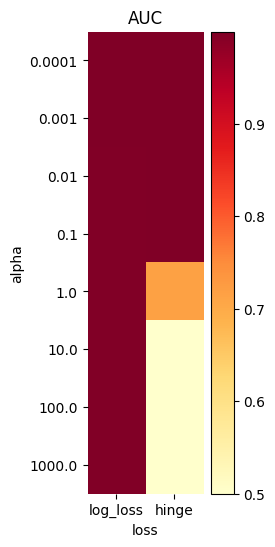

SGDClassifier(n_jobs=-1) 0.9997099806273931


In [20]:


mlflow.sklearn.autolog()


grid = {
    'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3], # learning rate
    'max_iter': [1000], # number of epochs
    'loss': ['log_loss','hinge'], # logistic regression,
    'penalty': ['l2'],
    'n_jobs': [-1]
}
paramGrid = ParameterGrid(grid)

bestModel, bestScore, allModels, allScores = pf.bestFit(SGDClassifier, paramGrid, X_train, y_train, X_val, y_val, metric = roc_auc_score,scoreLabel = "AUC")




print(bestModel, bestScore)

In [21]:

model = train(X_train, y_train)
y_pred = predict(X_test,  model)

2023/10/18 12:35:09 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '885d30210dd44546813326a9d5035c76', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


In [22]:

print(accuracy_score(y_test, y_pred))
print(roc_auc_score(y_test, y_pred))

0.9994571948760668
0.9997064153888607


In [23]:
print(model.coef_)

[[-0.08396784 -0.25125548  0.30890559  2.47134303  0.59539912  0.08934733
   0.03058343  0.08328535 -0.01868794 -6.67338345]]


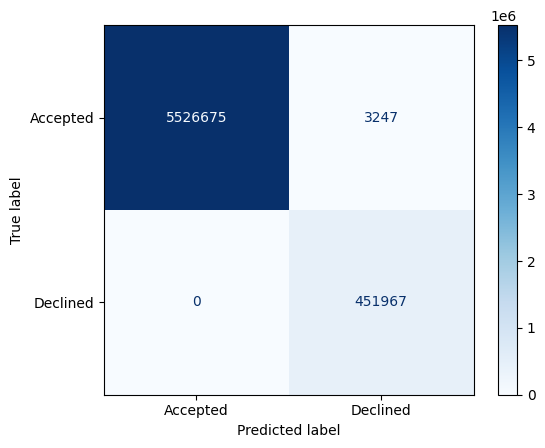

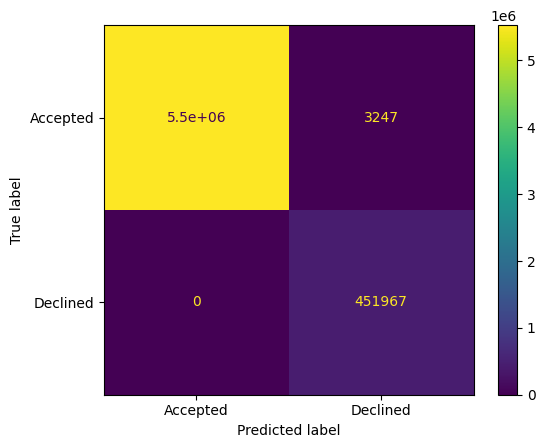

In [24]:

disp = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, 
                             cmap='Blues', values_format='d', 
                             display_labels=['Accepted', 'Declined'])
disp.plot()
plt.show()

In [25]:
output_file = f'model_Pred_1.bin'

In [26]:
with open(output_file, 'wb') as f_out :
    pickle.dump((scaler,numerical_imputer, model), f_out)

In [27]:
import requests
import json  # Import the 'json' module

# Define the URL of your Flask app
url = 'http://192.168.2.49:9696/predict'  # Update with the actual URL

# Sample data as a Python dictionary
sample_data = {
    "Amount Requested": 900000.0,
    "Debt-To-Income Ratio": 150.0,
    "employment Length": 10,
    "policy_code": 1,
    "risk_score": 800
}

# Serialize the Python dictionary into a JSON string
sample_data_json = json.dumps(sample_data)

# Send a POST request to your Flask app with JSON data
response = requests.post(url, data=sample_data_json, headers={'Content-Type': 'application/json'})

# Check the response
if response.status_code == 200:
    result = response.json()
    accepted_pred = result['accepted_pred']
    print(f"Accepted prediction: {accepted_pred}")
else:
    print(f"Request failed with status code: {response.status_code}")

ConnectionError: HTTPConnectionPool(host='192.168.2.49', port=9696): Max retries exceeded with url: /predict (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x00000230EEFEDA90>: Failed to establish a new connection: [WinError 10061] Aucune connexion n’a pu être établie car l’ordinateur cible l’a expressément refusée'))